<a id=contents></a>

# Exploratory Data Analysis
## Our clean data at a glance


[1. Visualizing the data](#insp)

[2. EDA for DS jobs](#one)

[3. EDA ML Eng jobs](#two)

[4. EDA 3](#three)

[5. Conclusions and ideas going forward](#conc)

In [76]:

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
import string

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id=insp ><a/> 

## 1. Visualizing the data
    
[LINK to table of contents](#contents)

In [77]:
df = pd.read_pickle('clean_data.pkl')
df.head()

,job_url,job_descr,is_mleng
0,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,would like reassure all applicant that recruit...,0
1,https://www.indeed.co.uk/rc/clk?jk=e96b45c3c7a...,Job Title Artificial Intelligence Data Scienti...,0
2,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,career within Forensics Technology service wil...,0
3,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,White Collar Factory 95009 United Kingdom Lond...,0
4,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,are digitally native technology where innovati...,0


In [78]:
# !pip install wordcloud
import wordcloud

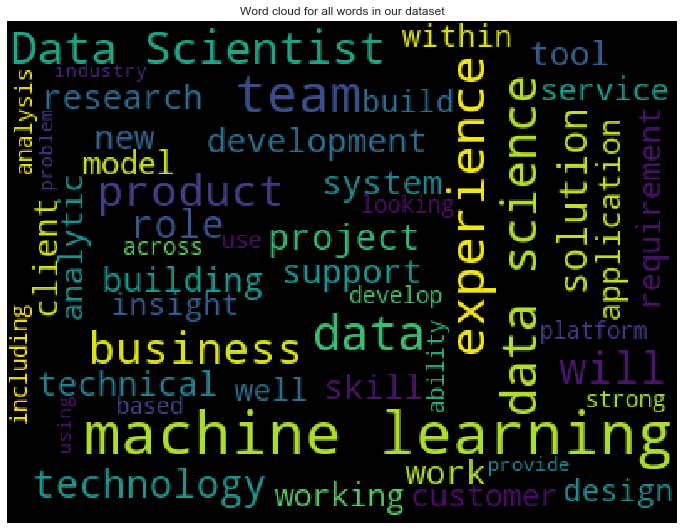

In [79]:
cloud_all = wordcloud.WordCloud(max_words=50, background_color='black', height=300, random_state=22)
plt.figure(figsize=(12,12))
cloud_all.generate(' '.join(df['job_descr']))
plt.imshow(cloud_all)
plt.title('Word cloud for all words in our dataset')
plt.axis("off")
plt.show()

<a id=one ><a/> 

## 2. EDA of Data Scientist Jobs
    
[LINK to table of contents](#contents)

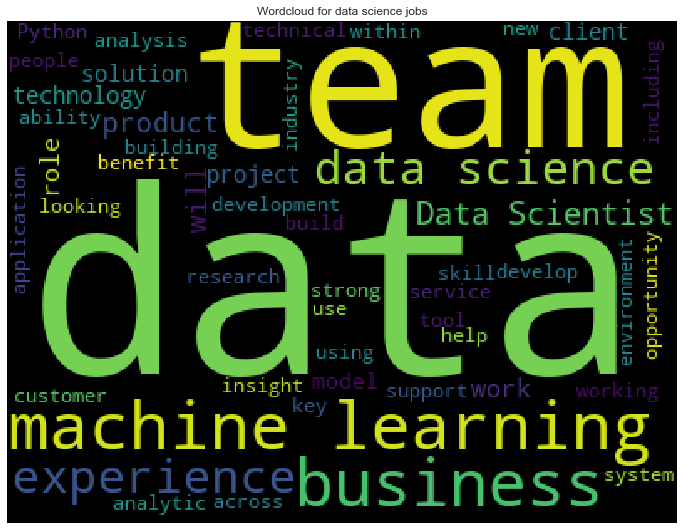

In [80]:
cloud_all = wordcloud.WordCloud(max_words=50, background_color='black', height=300, random_state=22)
plt.figure(figsize=(12,12))
cloud_all.generate(' '.join(df.loc[df['is_mleng']==0]['job_descr']))
plt.imshow(cloud_all)
plt.title('Wordcloud for data science jobs')
plt.axis("off")
plt.show()

<a id=two ><a/> 

## 3. EDA for ML Engineering jobs
    
[LINK to table of contents](#contents)

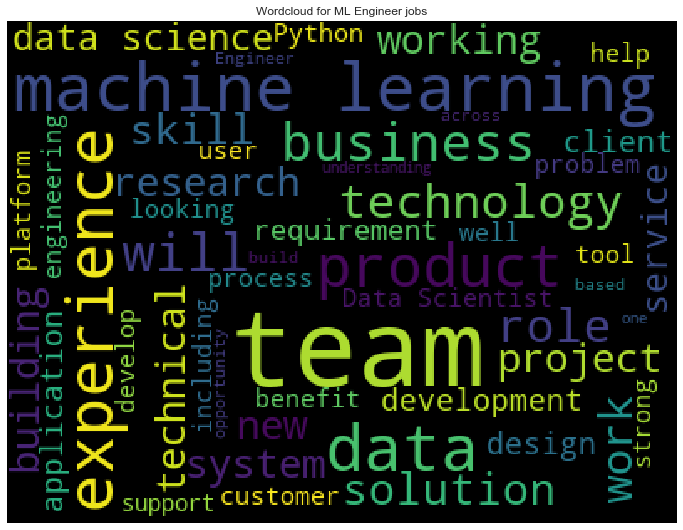

In [81]:
cloud_all = wordcloud.WordCloud(max_words=50, background_color='black', height=300, random_state=22)
plt.figure(figsize=(12,12))
cloud_all.generate(' '.join(df.loc[df['is_mleng']==1]['job_descr']))
plt.imshow(cloud_all)
plt.title('Wordcloud for ML Engineer jobs')
plt.axis("off")
plt.show()

<a id=three ><a/> 

## 4. Latent Semantic Analysis for exploration
    
[LINK to table of contents](#contents)

In [105]:
for word in ['data','engineer', 'scientist', 'machine', 'learning', 'science', 'engineering', 'software']:
    stop_words.append(word)
stop_words

['aren',
 "you've",
 's',
 'between',
 'only',
 'when',
 'my',
 'nor',
 'herself',
 'been',
 "hasn't",
 'each',
 'wasn',
 'll',
 "doesn't",
 "haven't",
 'i',
 'so',
 "couldn't",
 'hadn',
 'weren',
 'too',
 'we',
 'm',
 'is',
 'up',
 'of',
 'hasn',
 'any',
 'further',
 'own',
 'same',
 'our',
 'he',
 'again',
 't',
 'above',
 "aren't",
 'd',
 "needn't",
 'just',
 'doesn',
 'what',
 'out',
 'for',
 'its',
 "shouldn't",
 'not',
 'about',
 'in',
 'why',
 "should've",
 'couldn',
 'some',
 'be',
 'have',
 'by',
 're',
 'which',
 'has',
 'under',
 'or',
 "hadn't",
 'but',
 'o',
 'doing',
 'don',
 'against',
 'his',
 'were',
 'theirs',
 'until',
 'am',
 'himself',
 "don't",
 'from',
 'as',
 'me',
 'then',
 'than',
 'an',
 'there',
 "mightn't",
 'mightn',
 'no',
 'this',
 'during',
 'y',
 "mustn't",
 'below',
 'whom',
 'does',
 "shan't",
 'was',
 "you'll",
 'before',
 'once',
 'can',
 'with',
 'won',
 'do',
 'they',
 'her',
 'here',
 'few',
 'mustn',
 'she',
 'should',
 'off',
 "isn't",
 "weren

In [106]:
tf_idf = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                         stop_words = stop_words, ngram_range=(1,3),
                        max_df = 0.75,
                        min_df = 0.1)

In [107]:
doc_term_matrix = tf_idf.fit_transform(df.job_descr)

doc_term_df = pd.DataFrame(doc_term_matrix.toarray(), columns = tf_idf.get_feature_names())

doc_term_df.head()

,000,2019,2020,ability,able,academic,access,across,additional,advanced,...,well,wide,within,work home,world,world class,would,written,year,year experience
0,0.0,0.0,0.043953,0.000000,0.035824,0.0,0.047067,0.026835,0.000000,0.000000,...,0.064249,0.000000,0.056323,0.0,0.000000,0.0,0.075726,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.072245,0.000000,...,0.097580,0.075559,0.042771,0.0,0.000000,0.0,0.057506,0.0,0.039763,0.0
2,0.0,0.0,0.000000,0.096340,0.042230,0.0,0.000000,0.031634,0.000000,0.083352,...,0.113606,0.000000,0.165986,0.0,0.089285,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.052449,0.000000,0.0,0.000000,0.077500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.072258,...,0.000000,0.101680,0.057558,0.0,0.000000,0.0,0.077386,0.0,0.000000,0.0


In [108]:
for i, c in enumerate(doc_term_df.columns):
    print(i, c)

0 000
1 2019
2 2020
3 ability
4 able
5 academic
6 access
7 across
8 additional
9 advanced
10 age
11 agile
12 aim
13 algorithm
14 alongside
15 also
16 analysis
17 analyst
18 analytical
19 analytics
20 application
21 applied
22 apply
23 applying
24 approach
25 appropriate
26 architecture
27 area
28 around
29 around world
30 artificial
31 artificial intelligence
32 available
33 aws
34 background
35 bank
36 base
37 based
38 behaviour
39 believe
40 benefit
41 benefits
42 best
43 best practice
44 better
45 big
46 board
47 bonus
48 bring
49 build
50 building
51 business
52 candidate
53 capability
54 career
55 central
56 challenge
57 challenging
58 chance
59 change
60 changing
61 class
62 client
63 closely
64 cloud
65 company
66 computer
67 create
68 creating
69 creative
70 critical
71 cross
72 culture
73 current
74 currently
75 customer
76 cycle
77 database
78 datasets
79 date
80 day
81 day holiday
82 decision
83 deep
84 degree
85 deliver
86 delivering
87 delivery
88 demonstrate
89 descriptio

In [109]:
lsa_obj = TruncatedSVD(n_components=100, n_iter=100, random_state=22)

lsa_df = pd.DataFrame(lsa_obj.fit_transform(doc_term_df), 
                      columns = [f'Latent_concept_{x+1}' for x in range(lsa_obj.n_components)])
lsa_df.head()

,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9,Latent_concept_10,...,Latent_concept_91,Latent_concept_92,Latent_concept_93,Latent_concept_94,Latent_concept_95,Latent_concept_96,Latent_concept_97,Latent_concept_98,Latent_concept_99,Latent_concept_100
0,0.466992,-0.156027,-0.001619,-0.073447,-0.058095,-0.051649,-0.030180,0.060548,0.091358,-0.076855,...,-0.039775,0.137546,-0.008211,-0.042349,-0.002177,0.055452,-0.003975,-0.039418,-0.016074,-0.001242
1,0.513629,-0.052682,-0.009037,0.079564,-0.111409,0.089800,-0.025123,-0.287303,-0.032248,-0.077458,...,0.070856,0.011300,0.036410,0.019368,0.058717,-0.002757,0.067151,-0.003102,0.019722,-0.024124
2,0.592771,-0.116595,-0.264328,0.149185,0.076438,-0.148920,0.116432,-0.099436,0.164464,0.049470,...,-0.032172,-0.013603,0.018608,-0.003124,0.011897,0.024522,0.024497,0.089210,0.042347,-0.003335
3,0.489814,-0.065505,-0.074605,-0.021227,-0.043676,0.172990,0.013455,0.040519,-0.117869,0.030651,...,-0.097444,-0.041908,-0.014549,-0.010265,-0.029991,0.014751,0.018826,0.009375,0.021595,0.066275
4,0.452284,-0.054075,-0.037288,-0.000035,-0.009771,-0.022736,0.082586,0.008330,-0.060352,-0.007453,...,0.050927,-0.067626,-0.020012,0.082386,0.050921,-0.036128,0.073147,0.093264,-0.006534,0.059229


In [110]:
V_T = lsa_obj.components_.T
V_T.shape

(474, 100)

In [111]:
term_topic_matrix = pd.DataFrame(data=V_T, 
                                 index = doc_term_df.columns, 
                                 columns = [f'Latent_concept_{x+1}' for x in range(lsa_obj.n_components)])

term_topic_matrix.head()

,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9,Latent_concept_10,...,Latent_concept_91,Latent_concept_92,Latent_concept_93,Latent_concept_94,Latent_concept_95,Latent_concept_96,Latent_concept_97,Latent_concept_98,Latent_concept_99,Latent_concept_100
000,0.060472,-0.038527,0.092773,-0.156130,0.337094,0.137048,-0.037690,-0.042074,0.084001,-0.079734,...,0.011442,0.025487,-0.110736,-0.001649,-0.023235,-0.034162,-0.066864,-0.046394,-0.009789,0.011158
2019,0.022780,0.076673,0.045163,0.063353,0.016541,-0.020833,0.001053,-0.000369,-0.024844,0.013161,...,-0.012600,0.010368,0.037996,0.030918,-0.001155,0.038507,-0.018500,-0.013248,-0.058816,-0.026590
2020,0.028477,0.051231,0.000095,-0.016447,0.024220,-0.028100,0.034851,0.003165,-0.020748,-0.013822,...,-0.002309,0.020776,-0.023854,-0.057150,0.015753,0.000649,-0.029512,0.032169,-0.017463,-0.046334
ability,0.089193,-0.024956,-0.025300,0.073345,-0.061168,-0.057222,-0.166515,0.039287,-0.040226,0.072390,...,-0.054219,-0.055991,0.026478,-0.047827,0.068481,0.003238,0.023663,-0.024892,-0.062740,0.038891
able,0.048812,-0.030127,-0.022817,-0.017497,0.030511,-0.006802,-0.034539,0.006695,0.032413,-0.013039,...,0.028983,-0.046582,-0.000619,-0.002553,0.055181,-0.016313,-0.060317,0.044274,-0.055053,0.122284


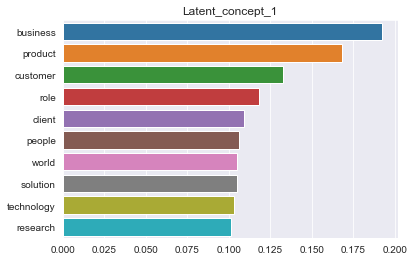

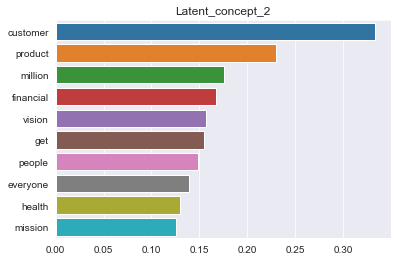

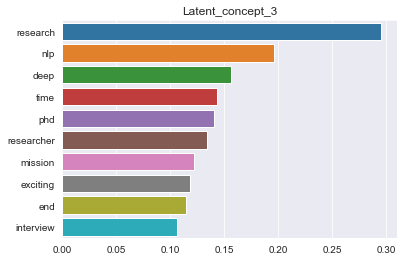

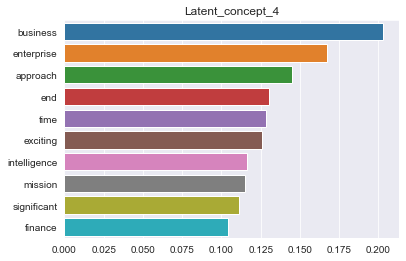

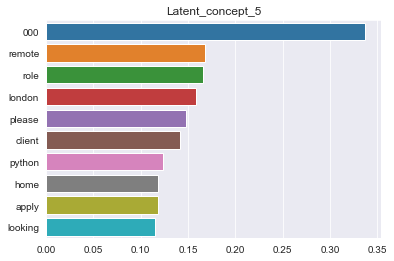

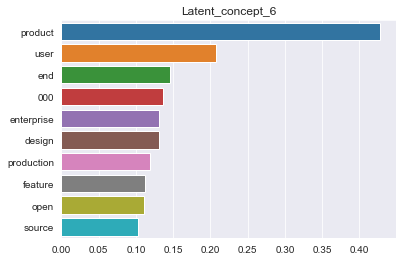

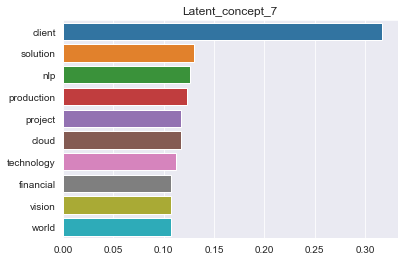

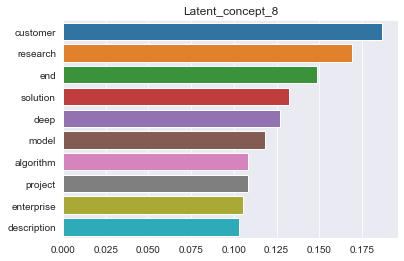

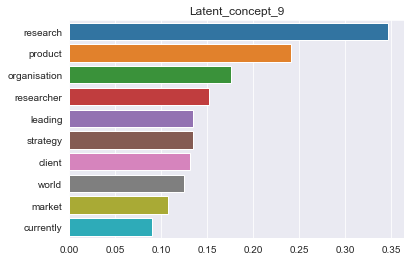

In [112]:
for i in range(1,10):
    data = term_topic_matrix[f'Latent_concept_{i}']
    data = data.sort_values(ascending=False)
    top_10 = data[:10]
    plt.title(f'Latent_concept_{i}')
    sns.barplot(y=top_10.index, x=top_10.values)
    plt.show()

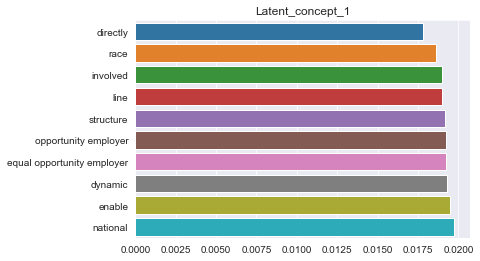

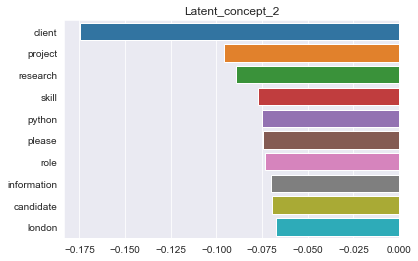

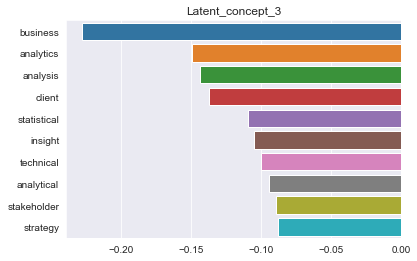

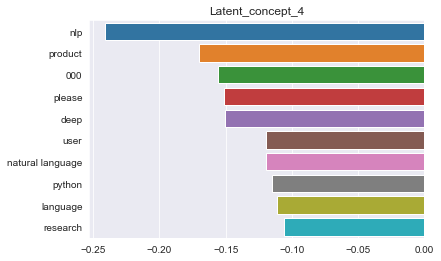

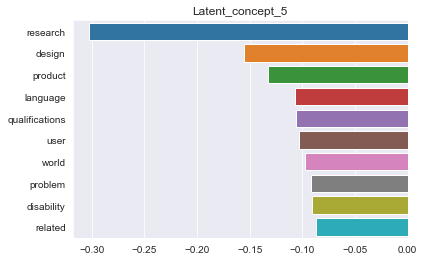

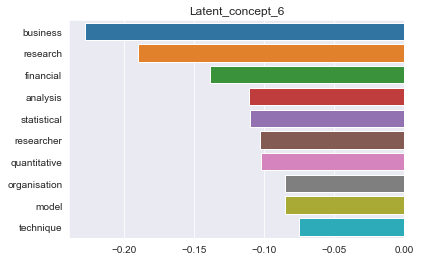

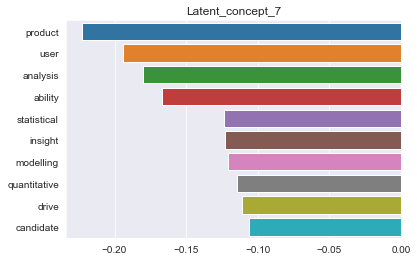

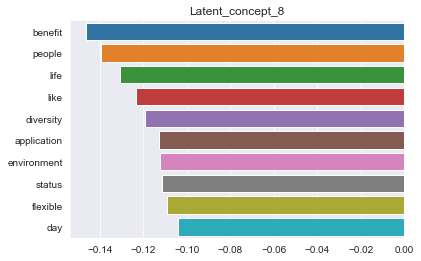

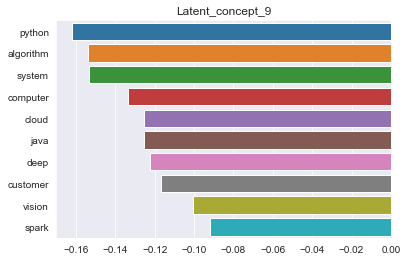

In [113]:
for i in range(1,10):
    data = term_topic_matrix[f'Latent_concept_{i}']
    data = data.sort_values(ascending=True)
    bottom_10 = data[:10]
    plt.title(f'Latent_concept_{i}')
    sns.barplot(y=bottom_10.index, x=bottom_10.values)
    plt.show()

In [114]:
tree = DecisionTreeClassifier(min_samples_leaf=.1,
                              random_state=22)

tree.fit(doc_term_df, df.is_mleng)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=22, splitter='best')

In [115]:
importances = tree.feature_importances_
feats = pd.DataFrame({'features': doc_term_df.columns, 'importance': importances})

feats.sort_values(by = 'importance',ascending=False, inplace=True)

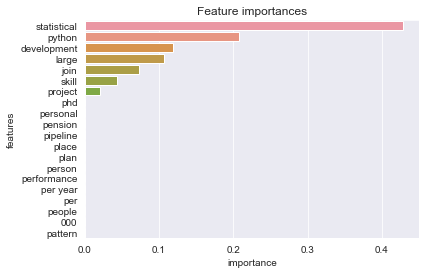

In [116]:
plt.figure()
plt.title("Feature importances")
sns.barplot(x=feats[:20].importance, y = feats[:20].features, orient='h')
plt.show()


<a id=conc ><a/> 

## 4. Conclusions and ideas going forward
    
[LINK to table of contents](#contents)